# AI300: Capstone Project Data Modeling

In [1]:
import pandas as pd 
from pycaret.classification import *

In [2]:
df = pd.read_csv('data/customer_churn_clean_v0.csv')
df.head()

,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,...,stream_movie,stream_music,total_monthly_fee,gender,senior_citizen,married,num_dependents,zip_code,city_name,churn_label
0,3,3,1,1,1,1,0,1,0,0,...,0,0,83.90,1,1,1,0,606,139,1
1,63,8,1,1,0,1,1,1,1,0,...,0,0,84.65,0,0,1,0,962,653,0
2,65,3,1,3,1,1,1,1,1,1,...,1,1,90.45,1,0,1,1,1389,915,0
3,72,0,1,1,1,1,1,0,1,1,...,0,0,101.30,1,0,0,0,302,490,0
4,56,0,1,2,1,0,0,1,1,1,...,0,0,45.05,1,0,0,0,715,558,0


In [3]:
df.shape

(7043, 26)

## Preliminary assessment of models to explore

In [3]:
s = setup(data = df, target='churn_label', session_id=42)

,Description,Value
0,Session id,42
1,Target,churn_label
2,Target type,Binary
3,Original data shape,"(7043, 26)"
4,Transformed data shape,"(7043, 26)"
5,Transformed train set shape,"(4930, 26)"
6,Transformed test set shape,"(2113, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


In [5]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8544,0.9100,0.6613,0.7592,0.7063,0.6101,0.6131,0.0200
catboost,CatBoost Classifier,0.8542,0.9121,0.6628,0.7586,0.7063,0.6101,0.6133,0.0130
lightgbm,Light Gradient Boosting Machine,0.8519,0.9067,0.6720,0.7462,0.7063,0.6078,0.6099,0.0270
rf,Random Forest Classifier,0.8442,0.8943,0.6246,0.7485,0.6803,0.5785,0.5831,0.0360
xgboost,Extreme Gradient Boosting,0.8432,0.9015,0.6567,0.7278,0.6892,0.5849,0.5872,0.0150
lr,Logistic Regression,0.8365,0.8912,0.6544,0.7085,0.6799,0.5704,0.5716,0.0190
et,Extra Trees Classifier,0.8345,0.8814,0.5932,0.7329,0.6549,0.5477,0.5535,0.0470
ada,Ada Boost Classifier,0.8341,0.8951,0.6575,0.6997,0.6773,0.5658,0.5668,0.0190
ridge,Ridge Classifier,0.8329,0.0000,0.5924,0.7279,0.6525,0.5441,0.5495,0.0120
lda,Linear Discriminant Analysis,0.8310,0.8821,0.6315,0.7024,0.6645,0.5521,0.5539,0.0130


Based on the comparison, the models selected for experimentations are `catboost` and `gradient boosting classifier`. 

## Modeling

In [4]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier


In [5]:
# Train-test split 
X = df.drop(columns="churn_label")
y = df['churn_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4930, 25)
Shape of X_test: (2113, 25)
Shape of y_train: (4930,)
Shape of y_test: (2113,)


### Gradient Boosting Classifer

In [8]:
# Hyperparamter tuning for Gradient Boosting Classifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

gbc = GradientBoostingClassifier(random_state=42)
space = dict() 
space['learning_rate'] = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
space['n_estimators'] = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300]
space['max_depth'] = [int(x) for x in np.linspace(1, 32, 32, endpoint=True)]
space['min_samples_split'] = np.linspace(0.1, 1.0, 10, endpoint=True)
space['min_samples_leaf'] = np.linspace(0.1, 0.5, 5, endpoint=True)
space['max_features'] = list(range(1, X_train.shape[1]))

# RandomSearchCV for best params
search = RandomizedSearchCV(gbc, space, n_iter=1000, scoring='roc_auc', cv=10, n_jobs=-1, random_state=42)
result = search.fit(X, y)
print (f"Best score: {result.best_score_}")
print(f"Best Hyperparameters for Gradient Boosting Classifier based on RandomizedSearchCV: {result.best_params_}")

Best score: 0.9089940590823293
Best Hyperparameters for Gradient Boosting Classifier based on RandomizedSearchCV: {'n_estimators': 300, 'min_samples_split': 0.4, 'min_samples_leaf': 0.1, 'max_features': 13, 'max_depth': 18, 'learning_rate': 0.25}


In [6]:
# Tuned model based on the above hyperparameters 
gbc_tuned = GradientBoostingClassifier(n_estimators=300, min_samples_split=0.4, min_samples_leaf=0.1, 
                                       max_features=13, max_depth=18, learning_rate=0.25, random_state=42)

gbc_tuned.fit(X_train, y_train)
y_pred = gbc_tuned.predict(X_test)

Confusion Matrix


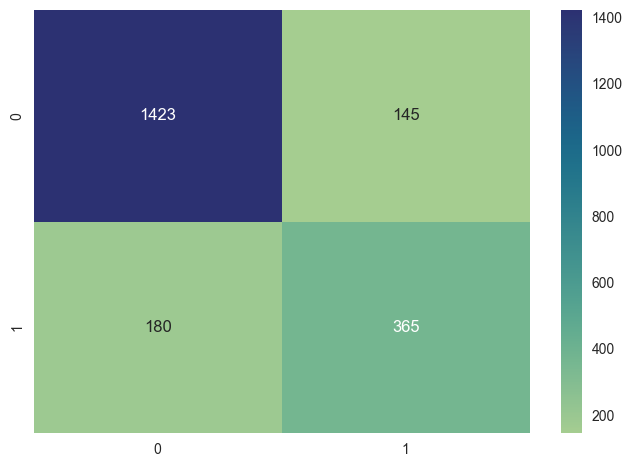

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1568
           1       0.72      0.67      0.69       545

    accuracy                           0.85      2113
   macro avg       0.80      0.79      0.79      2113
weighted avg       0.84      0.85      0.84      2113



In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='.0f', cmap='crest')
plt.show()

print("Classification Report")
print(classification_report(y_test, y_pred))

In [8]:
y_pred_score = gbc_tuned.decision_function(X_test)
fpr_gbc_tuned, tpr_gbc_tuned, _ = roc_curve(y_test, y_pred_score)
roc_auc_gbctuned = auc(fpr_gbc_tuned, tpr_gbc_tuned)
print(f"Area under ROC curve (Tuned Gradient Boosting Classifier): {roc_auc_gbctuned:.2f}")

Area under ROC curve (Tuned Gradient Boosting Classifier): 0.90


### CatBoost Classifier

In [16]:
# Hyperparameter Tuning for CatBoost Classifier
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

cat = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', random_state=42, verbose=False)

space = dict() 
space['learning_rate'] = [0.5, 0.25, 0.1, 0.05, 0.025, 0.01]
space['depth'] = [int(x) for x in np.linspace(1, 15, 15, endpoint=True)]


# RandomSearchCV for best params 
search = RandomizedSearchCV(cat, space, n_iter=10, scoring='roc_auc', cv=10, n_jobs=-1, random_state=42)
result = search.fit(X, y)
print (f"Best score: {result.best_score_}")
print(f"Best Hyperparameters for CatBoost Classifier based on RandomizedSearchCV: {result.best_params_}")

Best score: 0.9159496727092218
Best Hyperparameters for CatBoost Classifier based on RandomizedSearchCV: {'learning_rate': 0.025, 'depth': 4}


In [17]:
# Tuned model based on the above hyperparameters 
cat_tuned = CatBoostClassifier(learning_rate= 0.025, depth = 4, eval_metric='AUC', 
                               random_state=42, verbose=False)

cat_tuned.fit(X_train, y_train)
y_pred = cat_tuned.predict(X_test)

Confusion Matrix


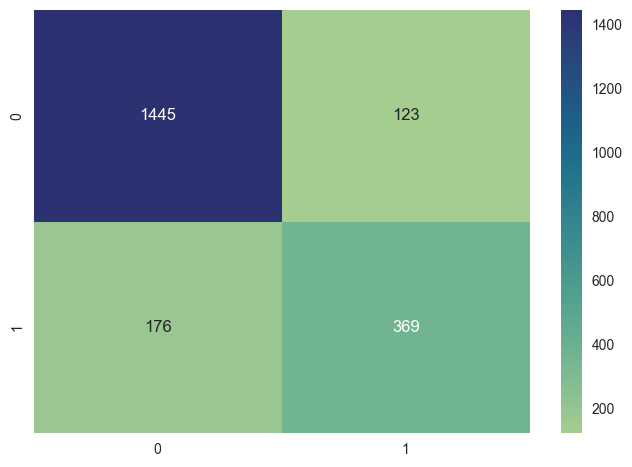

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1568
           1       0.75      0.68      0.71       545

    accuracy                           0.86      2113
   macro avg       0.82      0.80      0.81      2113
weighted avg       0.85      0.86      0.86      2113



In [18]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='.0f', cmap='crest')
plt.show()

print("Classification Report")
print(classification_report(y_test, y_pred))

In [19]:
y_pred_score = gbc_tuned.decision_function(X_test)
fpr_gbc_tuned, tpr_gbc_tuned, _ = roc_curve(y_test, y_pred_score)
roc_auc_gbctuned = auc(fpr_gbc_tuned, tpr_gbc_tuned)
print(f"Area under ROC curve (Tuned CatBoost Classifier): {roc_auc_gbctuned:.2f}")

Area under ROC curve (Tuned CatBoost Classifier): 0.90


In [20]:
import joblib 

joblib.dump(cat_tuned, 'catboost_model.pkl')

['catboost_model.pkl']